# Problem statement

The idea is to forecast the mean of all COVID beds in the US for the upcoming year based on historical data gathered and get the 95% and 80% intervals of the mean value corresponding to each day.

# Loading time series

In [14]:
# Importing the libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
pd.options.display.float_format = '{:.4f}'.format
import pmdarima as pm

In [15]:
# Setting graph/plot parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [16]:
# Loading data
data = pd.read_csv('Hospitalization_all_locs_29th_May_2020.csv')

# Printing first five rows and data type of each column
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

   V1 location_name        date  allbed_mean  allbed_lower  allbed_upper  \
0   1       Abruzzo  2019-12-21       0.0000        0.0000        0.0000   
1   2       Abruzzo  2019-12-22       0.0000        0.0000        0.0000   
2   3       Abruzzo  2019-12-23       0.0000        0.0000        0.0000   
3   4       Abruzzo  2019-12-24       0.0000        0.0000        0.0000   
4   5       Abruzzo  2019-12-25       0.0000        0.0000        0.0000   

   ICUbed_mean  ICUbed_lower  ICUbed_upper  InvVen_mean  ...  \
0       0.0000        0.0000        0.0000       0.0000  ...   
1       0.0000        0.0000        0.0000       0.0000  ...   
2       0.0000        0.0000        0.0000       0.0000  ...   
3       0.0000        0.0000        0.0000       0.0000  ...   
4       0.0000        0.0000        0.0000       0.0000  ...   

   totdea_lower_smoothed  totdea_upper_smoothed  mobility_data_type  \
0                    nan                    nan                 NaN   
1               

# Data Wrangling

* We're grouping by date and applying sum because we have data on states, and all the mean points corresponding to states add up to resemble those for countries. 
* We're also eliminating all rows that have zeroes in mean, lower bound, and upper bound columns

In [17]:
data = data[['date', 'InvVen_mean',  'InvVen_lower',  'InvVen_upper']] .groupby(['date']).sum().reset_index()
data = data[(data['InvVen_mean']!=0) & (data['InvVen_lower']!=0) & (data['InvVen_upper']!=0)]

In [18]:
# Fetching only columns of interest
InvVenData = data[['date', 'InvVen_mean']]
InvVenData.head()

,date,InvVen_mean
44,2020-01-26,1.0000
45,2020-01-27,2.0000
46,2020-01-28,3.0000
47,2020-01-29,3.3869
48,2020-01-30,3.7747


### Datetime conversion

Since, date column is having object data type, let's resolve that 

In [19]:
InvVenData['date'] = pd.to_datetime(InvVenData['date'])

Now, since there are multiple values corresponding to one date because we removed location column from this data, we need to group these dates and find out the final All COVID beds value corresponding to each date.

### Grouping the column by date

In [20]:
InvVenData = InvVenData.groupby(['date']).sum().reset_index()
InvVenData.iloc[50:100]

,date,InvVen_mean
50,2020-03-16,13178.0625
51,2020-03-17,15133.8534
52,2020-03-18,17288.6172
53,2020-03-19,19645.5320
54,2020-03-20,22220.5415
55,2020-03-21,25007.5381
56,2020-03-22,28008.6938
57,2020-03-23,31187.5892
58,2020-03-24,34554.7744
59,2020-03-25,38103.0960


In [21]:
#setting index to date
InvVenData = InvVenData.set_index('date')
InvVenData.index

DatetimeIndex(['2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04',
               ...
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
               '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11'],
              dtype='datetime64[ns]', name='date', length=230, freq=None)

In [22]:
# Keeping historical data till 25th April 2020
InvVenData = InvVenData[InvVenData.index <= '2020-05-29']
InvVenData.columns = ['value']
InvVenData.tail()

,value
date,
2020-05-25,56348.7136
2020-05-26,55940.5395
2020-05-27,55572.6527
2020-05-28,55242.2040
2020-05-29,54923.5516


### Missing value analysis

We'll check is there's any missing value present in our data by applying isnull function on the dataset.

In [23]:
InvVenData.isnull().any()

value    False
dtype: bool

Since, we get 'False' as the result, we can say that there are no missing values in the dataset.

### Detecting outliers

Firstly, let's follow graphical procedure to analyse if the data contains outliers or not. We'll use boxplot for this.

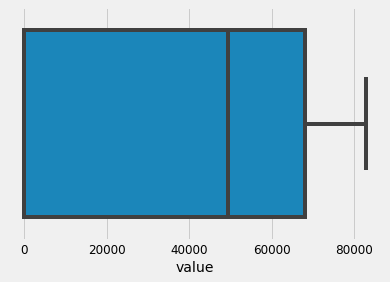

In [24]:
import seaborn as sns
sns.boxplot(x=InvVenData['value'])

The boxplot tells that there're no outliers in the data as there's no point which is lying outside of whiskers. Let's now see this via z-scores.

In [26]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(InvVenData))
print(z)

[[1.14455895]
 [1.14452855]
 [1.14449815]
 [1.14448638]
 [1.14447459]
 [1.14446257]
 [1.14449298]
 [1.14452338]
 [1.14455379]
 [1.14455379]
 [1.14437136]
 [1.14424974]
 [1.14418893]
 [1.14408883]
 [1.14406263]
 [1.14404947]
 [1.14423086]
 [1.14436427]
 [1.14443709]
 [1.1444979 ]
 [1.1444979 ]
 [1.1444675 ]
 [1.14443709]
 [1.14440669]
 [1.14436918]
 [1.14427098]
 [1.14418157]
 [1.14410954]
 [1.14397994]
 [1.14384169]
 [1.14359948]
 [1.14341401]
 [1.14106878]
 [1.13815445]
 [1.13475443]
 [1.1301717 ]
 [1.12458246]
 [1.117751  ]
 [1.1110243 ]
 [1.10302838]
 [1.093147  ]
 [1.08135494]
 [1.06743409]
 [1.05110223]
 [1.03301485]
 [0.99912543]
 [0.96059824]
 [0.91698521]
 [0.8658667 ]
 [0.80833122]
 [0.74391759]
 [0.68445284]
 [0.61893842]
 [0.54727772]
 [0.46898597]
 [0.38424886]
 [0.29300037]
 [0.19634779]
 [0.09397037]
 [0.0139144 ]
 [0.12598699]
 [0.23903774]
 [0.35397378]
 [0.47004604]
 [0.58523133]
 [0.69717736]
 [0.8046065 ]
 [0.90525004]
 [0.99839117]
 [1.08145603]
 [1.15352965]
 [1.21

As can be seen from above array, every value has z-score less than +3 or greater than -3. Thus, no outliers are present in the data.

# Time-series analysis

### Extracting time series from dataframe

In [27]:
# Converting allBedData into time-series
ts = InvVenData['value']
ts.head()

date
2020-01-26   1.0000
2020-01-27   2.0000
2020-01-28   3.0000
2020-01-29   3.3869
2020-01-30   3.7747
Name: value, dtype: float64

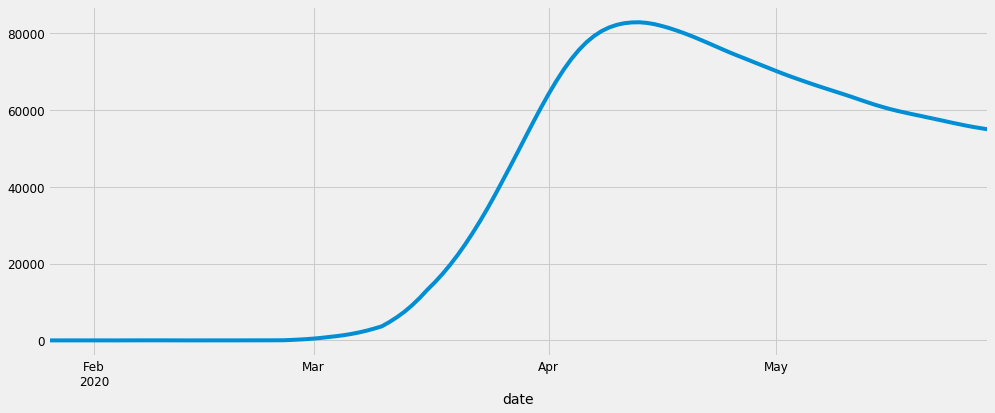

In [28]:
# Visualizing the time-series
pd.plotting.register_matplotlib_converters()
ts.plot(figsize=(15, 6))
plt.show()

The time-series stays close to 0 till the end of February 2020 and begins increasing after that. It keeps on increasing till mid-April where it reaches the highest point and then begins decreasing.

### Decomposing the time-series

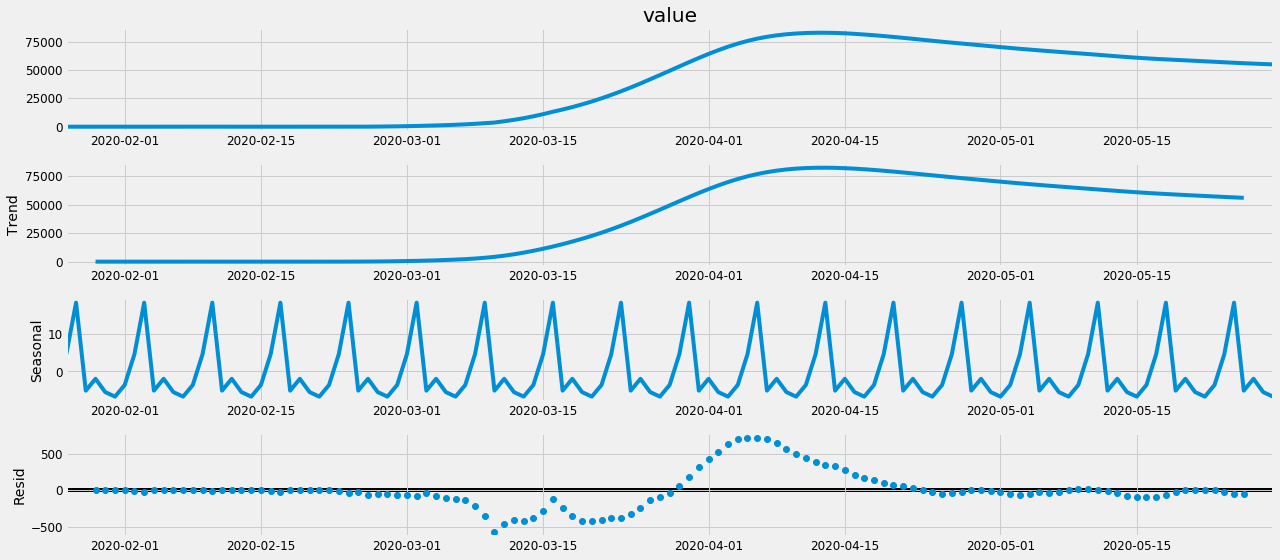

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

We can see that besides trend, there is high amount of seasonality within the data.

# Checking Stationarity

 In a time-series, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

In [30]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

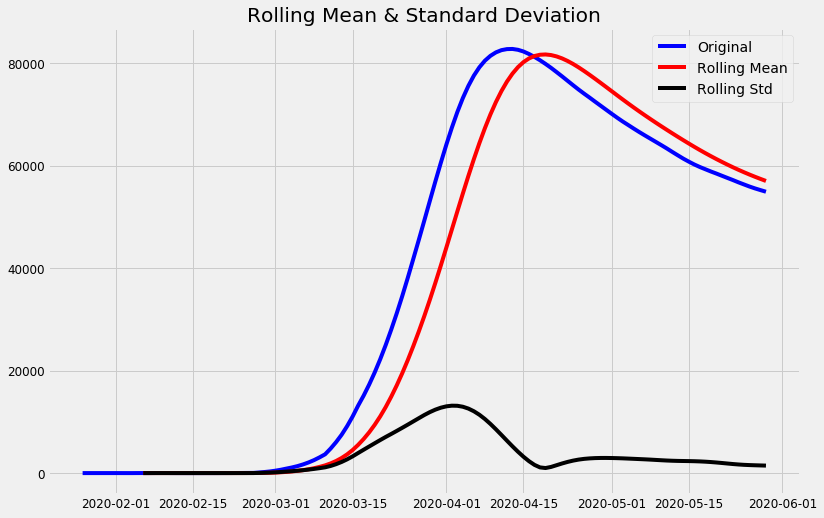

Results of Dickey-Fuller Test:
p-value = 0.4291. The series is likely non-stationary.
Test Statistic                 -1.7039
p-value                         0.4291
#Lags Used                     14.0000
Number of Observations Used   110.0000
Critical Value (1%)            -3.4912
Critical Value (5%)            -2.8882
Critical Value (10%)           -2.5810
dtype: float64


In [31]:
test_stationarity(ts)

We can see that this time-series is non-stationary with p value of 0.4291.

# Plotting ACF and PACF 

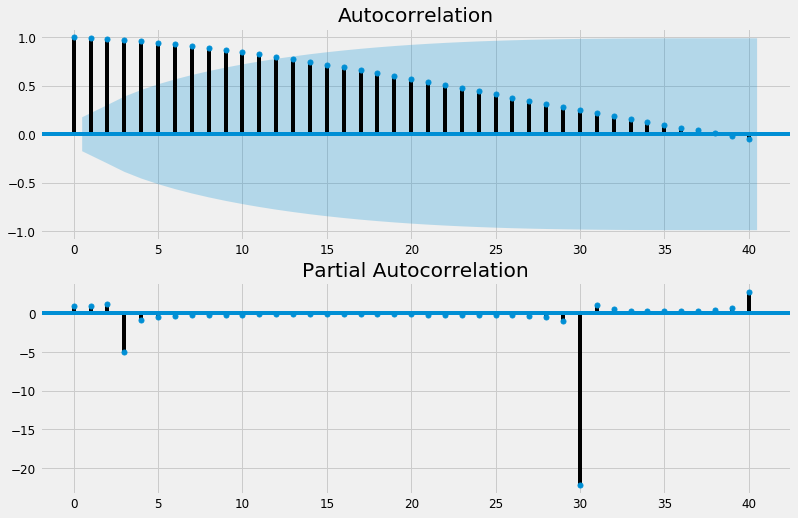

In [32]:
# Plotting ACF
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)# , lags=40

Since seasonality is also present in the data as can be seen from above graphs, after 7 days, we're seeing some sine wave like pattern, let's consider SARIMA.

# Forecasting Time-Series with ARIMA

### Understanding ARIMA

ARIMA, an acronym for Autoregressive Integrated Moving Average, is a combination of two terms - (i) AR (ii) MA
* AR corresponds to the difference value. This is today's value minus yesterday's value or value-on-value change.
* MA corresponds to moving average terms.

Besides this, we have seen that there's high amount of seasonality in the time-series. Therefore, we will be using Seasonal ARIMA or SARIMA in this case.

# ARIMA

In [33]:
# Keeping the p, d and q to be bounded in (0,3)
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
#pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for  ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[2]))
print('ARIMA: {}'.format(pdq[3]))
print('ARIMA: {}'.format(pdq[4]))

Examples of parameter combinations for  ARIMA...
ARIMA: (0, 0, 1)
ARIMA: (0, 0, 2)
ARIMA: (0, 1, 0)
ARIMA: (0, 1, 1)


In [34]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [35]:
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
for x in pdq:
    try:
        #print(x)
        mod = ARIMA(ts, order =x)
        mod_fit = mod.fit()
        print('ARIMA{} - AIC:{}'.format(x, mod_fit.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:2958.965009858312
ARIMA(0, 1, 0) - AIC:2141.5787219528956
ARIMA(0, 2, 0) - AIC:1553.62759423125
ARIMA(0, 2, 1) - AIC:1489.2434554846495
ARIMA(0, 2, 2) - AIC:1451.1299222247976
ARIMA(1, 1, 1) - AIC:1506.9154115143333
ARIMA(1, 1, 2) - AIC:1468.6399652522307
ARIMA(1, 2, 0) - AIC:1416.1853846332122
ARIMA(1, 2, 1) - AIC:1398.9296514638106
ARIMA(1, 2, 2) - AIC:1396.5221141272473
ARIMA(2, 0, 1) - AIC:1511.885461633709
ARIMA(2, 0, 2) - AIC:1480.520310662836
ARIMA(2, 1, 1) - AIC:1405.968332612031
ARIMA(2, 1, 2) - AIC:1404.8294902971033
ARIMA(2, 2, 0) - AIC:1398.0865117404553
ARIMA(2, 2, 1) - AIC:1398.5172051463408
ARIMA(2, 2, 2) - AIC:1392.8329908193132


We can see that (2, 2, 2) - AIC:1392.833 corresponds to the lowest AIC value of 1392.83.

# Running diagnosis

In [36]:
mod = ARIMA(ts,order=(2, 2, 2))
                                
results = mod.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  123
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -690.416
Method:                       css-mle   S.D. of innovations             65.821
Date:                Sun, 14 Jun 2020   AIC                           1392.833
Time:                        23:31:22   BIC                           1409.706
Sample:                    01-28-2020   HQIC                          1399.687
                         - 05-29-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1616     28.972     -0.075      0.941     -58.946      54.622
ar.L1.D2.value     1.8934      0.078     24.414      0.000       1.741       2.045
ar.L2.D2.value    -0.9124      0.071

In [37]:
m = pm.ARIMA(order=(2,2,2))
z = m.fit(ts)

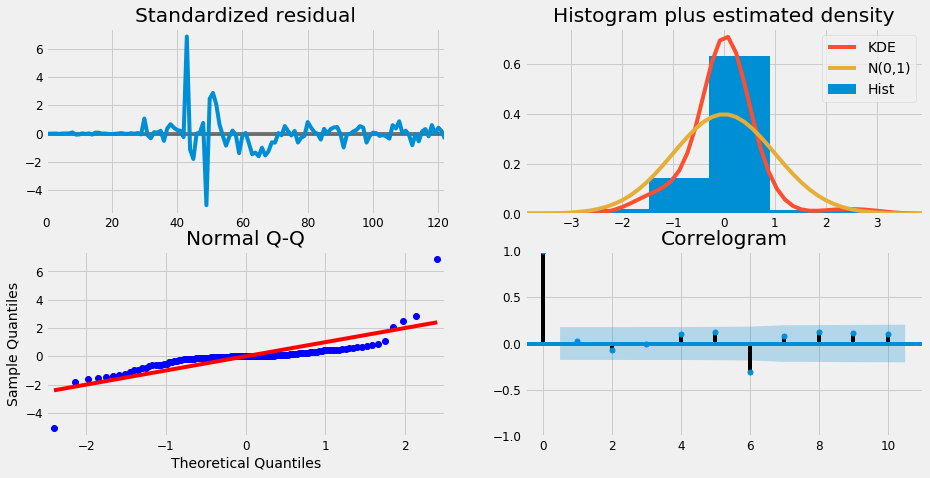

In [38]:
z.plot_diagnostics(figsize=(14, 7));

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The histogram suggests that the residuals have normal distribution.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The more close the sample quantiles to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

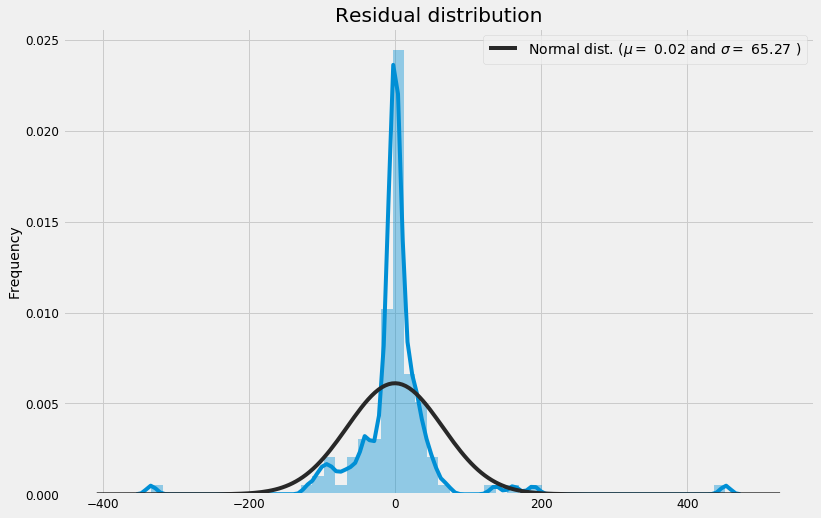

In [39]:
resid = z.resid()

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit= stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high. 

# Validating forecasts

Choosing 35th number in z.predict(len(ts)) (the 1st of March) as a reference point to start validating the forecasts.

In [40]:
z.predict(len(ts))

array([54635.35439144, 54371.48102002, 54127.52070689, 53900.13389793,
       53686.68514102, 53485.02932344, 53293.3821829 , 53110.23787615,
       52934.31345754, 52764.50927031, 52599.87917167, 52439.60716613,
       52282.98846294, 52129.41376345, 51978.35602454, 51829.35919449,
       51682.02856537, 51536.0224761 , 51391.04515885, 51246.84056151,
       51103.18700769, 50959.892578  , 50816.79111362, 50673.73875747,
       50530.61096032, 50387.29988912, 50243.71218325, 50099.7670121 ,
       49955.39439335, 49810.53373701, 49665.13258484, 49519.14551898,
       49372.5332171 , 49225.26163428, 49077.30129476, 48928.62667867,
       48779.21569119, 48629.04920279, 48478.11065133, 48326.38569744,
       48173.86192624, 48020.52858905, 47866.37637973, 47711.39724115,
       47555.5841975 , 47398.93120919, 47241.4330472 , 47083.0851843 ,
       46923.88370085, 46763.82520326, 46602.9067534 , 46441.12580746,
       46278.48016302, 46114.96791326, 45950.58740728, 45785.33721573,
      

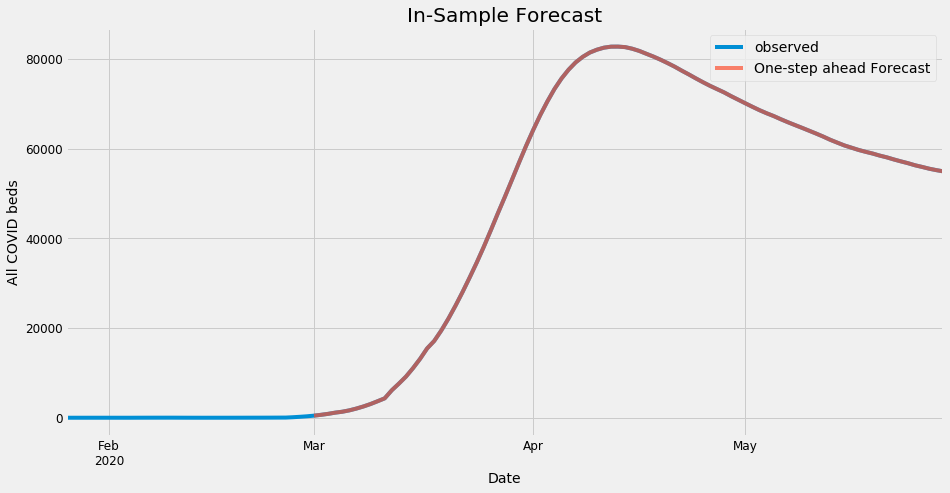

In [41]:
pred_int = z.predict_in_sample(start = 35, return_conf_int=True, alpha = 0.05)
df_pred = InvVenData[35:]
df_pred['value'] = pred_int[0]
ts_pred = df_pred['value']
ax = ts.plot(label='observed')
ts_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.title('In-Sample Forecast')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [43]:
ts_truth = ts['2020-04-01':]
df_pred = InvVenData[len(ts_truth):]
pred_int = z.predict_in_sample(start = len(ts_truth), return_conf_int=True, alpha = 0.05)
df_pred['value'] = pred_int[0]
ts_forecasted = df_pred['value']
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [44]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [45]:
ts.min()

1.0

In [46]:
ts.max()

82780.80632907464

This means that the value of RMSE is 0.0. Also, the minimum and maximum values of time series is 1.0 and 82780.80632907464 respectively. Overall, this is a very good model so far.

# Visualizing Forecast

In [47]:
from datetime import date, timedelta, datetime
next_100_days = []
datetime_str = '2020-05-29'
datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d')
for j in range(1, 101, 1):
        next_100_days.append((datetime_object + timedelta(days=j)).date())

In [48]:
next_100_days[0:6]

[datetime.date(2020, 5, 30),
 datetime.date(2020, 5, 31),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 2),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 4)]

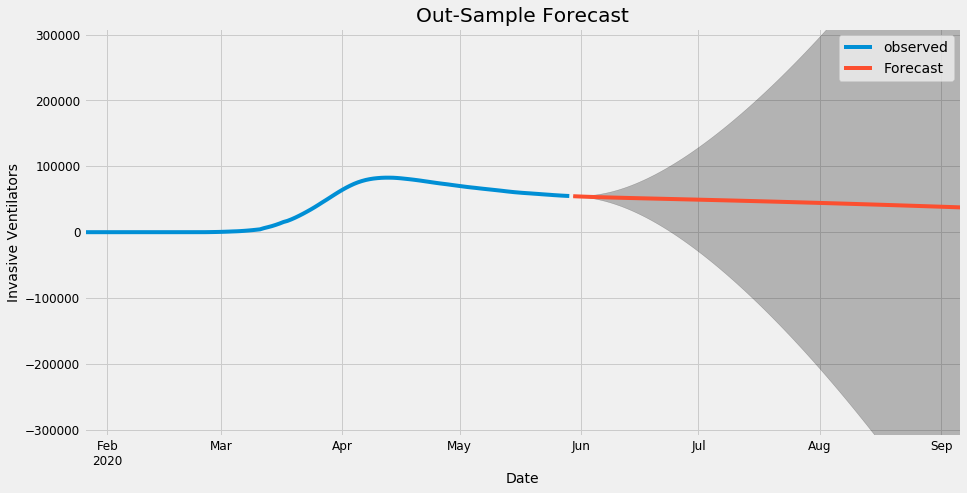

In [50]:
# Using the default confidence interval - 95%
pred_uc = z.predict(100, return_conf_int=True, alpha = 0.05)
pred_ci = pred_uc[0]

df_ci = pd.DataFrame(columns=['date', 'predicted_mean', 'lower', 'upper'])
df_ci['predicted_mean'] = pred_uc[0]
df_ci['date'] = next_100_days
df_ci['lower'] = pred_uc[1][:,0]
df_ci['upper'] = pred_uc[1][:,1]
df_ci['date'] = pd.to_datetime(df_ci['date'])
df_ci = df_ci.set_index('date')


# df_ci_2['date'] = next_100_days
# df_ci_2 = df_ci_2.set_index('date')
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(df_ci.index,
                df_ci.iloc[:, 1],
                df_ci.iloc[:, 2], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Invasive Ventilators')
plt.title('Out-Sample Forecast')
plt.ylim([-310000, 310000])
plt.legend()
plt.show()

Thus, in the future, the number of all COVID beds will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [51]:
df_ci.head()

,predicted_mean,lower,upper
date,,,
2020-05-30,54635.3544,54506.3671,54764.3417
2020-05-31,54371.4810,54039.6762,54703.2859
2020-06-01,54127.5207,53479.2886,54775.7528
2020-06-02,53900.1339,52798.9357,55001.3321
2020-06-03,53686.6851,51979.8726,55393.4977


In [52]:
# Setting all negative forecasted values to be 0
df_ci.predicted_mean[df_ci.predicted_mean < 0] = 0
df_ci.predicted_mean

date
2020-05-30   54635.3544
2020-05-31   54371.4810
2020-06-01   54127.5207
2020-06-02   53900.1339
2020-06-03   53686.6851
                ...    
2020-09-02   38456.6232
2020-09-03   38255.3971
2020-09-04   38053.2922
2020-09-05   37850.3084
2020-09-06   37646.4457
Name: predicted_mean, Length: 100, dtype: float64

In [53]:
df_ci['lower'][df_ci['lower'] < 0] = 0
df_ci['upper'][df_ci['upper'] < 0] = 0
df_ci

,predicted_mean,lower,upper
date,,,
2020-05-30,54635.3544,54506.3671,54764.3417
2020-05-31,54371.4810,54039.6762,54703.2859
2020-06-01,54127.5207,53479.2886,54775.7528
2020-06-02,53900.1339,52798.9357,55001.3321
2020-06-03,53686.6851,51979.8726,55393.4977
...,...,...,...
2020-09-02,38456.6232,0.0000,529370.2006
2020-09-03,38255.3971,0.0000,537467.3229
2020-09-04,38053.2922,0.0000,545610.0305


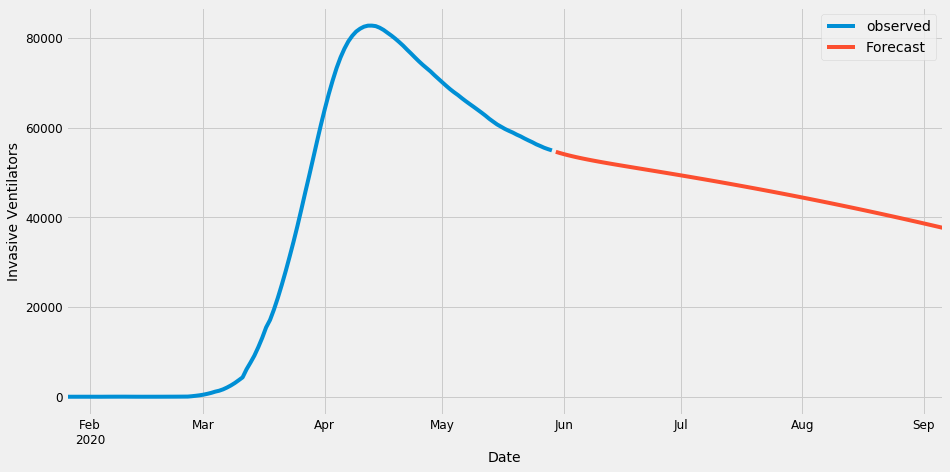

In [54]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Invasive Ventilators')
plt.legend()
plt.show()

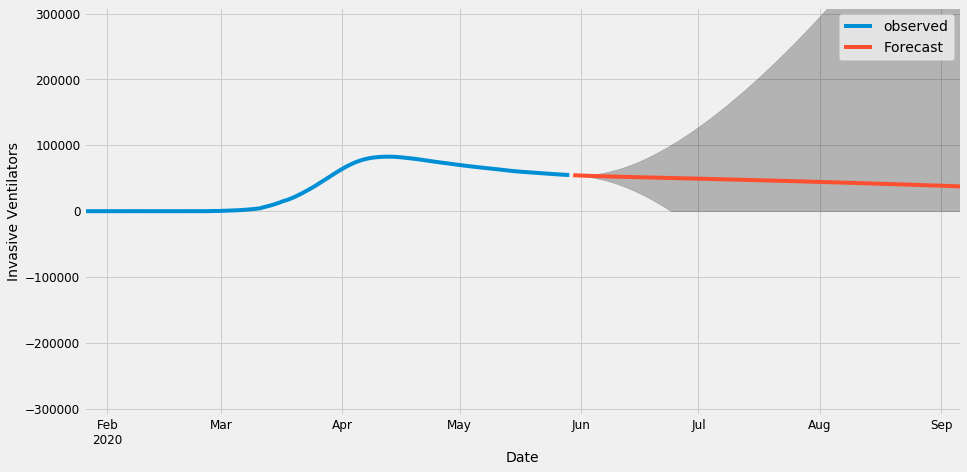

In [56]:
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(df_ci.index,
                df_ci.iloc[:, 1],
                df_ci.iloc[:, 2], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Invasive Ventilators')
plt.ylim([-310000, 310000])
plt.legend()
plt.show()

In [57]:
# Predictions dataframe
AllBedsPredictions = pd.DataFrame({'Predicted Mean All Beds':df_ci.predicted_mean, 
                                   'Predicted lower value':df_ci.iloc[:, 1], 
                                  'Predicted upper value': df_ci.iloc[:, 2]})

In [58]:
AllBedsPredictions.head(25)

,Predicted Mean All Beds,Predicted lower value,Predicted upper value
date,,,
2020-05-30,54635.3544,54506.3671,54764.3417
2020-05-31,54371.4810,54039.6762,54703.2859
2020-06-01,54127.5207,53479.2886,54775.7528
2020-06-02,53900.1339,52798.9357,55001.3321
2020-06-03,53686.6851,51979.8726,55393.4977
2020-06-04,53485.0293,51009.7377,55960.3210
2020-06-05,53293.3822,49881.0382,56705.7262
2020-06-06,53110.2379,48589.8409,57630.6349
2020-06-07,52934.3135,47134.7649,58733.8620


# Forecasting Time-Series with SARIMA

In [59]:
# Keeping the p, d and q to be bounded in (0,3)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 0, 2, 12)
SARIMA: (0, 0, 2) x (0, 1, 0, 12)
SARIMA: (0, 0, 2) x (0, 1, 1, 12)


This step is parameter selection for our SARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model. Parameters corresponding to lowest AIC are the ones that we'd choose.

In [60]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3038.1749622765838
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2692.414823772301
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:2422.211143274522
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2503.3522011730047
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2201.9482165200434
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1899.8875948214006
SARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:2220.2222097923113
SARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1924.9828440104625
SARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1689.8301636515293
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2525.8427598657076
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2452.3368729690033
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:2213.7131273683067
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2222.191842486902
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2170.997792487516
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1929.588112732176
SARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1982.6806908678166
SARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1940.2133864694606
SARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AI

SARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:1641.5427084318176
SARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC:1510.9597869274896
SARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:1587.5709030734579
SARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1504.8840597353183
SARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:1330.1534981206676
SARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:1428.0756172032416
SARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:1353.383852982739
SARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:1169.4954146864748
SARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:1530.7515573863168
SARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:1514.0779128674644
SARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:1477.19249789047
SARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:1367.5537165800024
SARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:1372.0410109851173
SARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:1325.2323133259356
SARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:1229.5866322581703
SARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:1209.0734334418141
SARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:1162.5401454312832
SARIMA(0, 2, 0)x(0, 0, 0, 12)12 - 

SARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:1650.938608092955
SARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:1426.7135834350702
SARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:1472.4018209404835
SARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:1457.0384262139717
SARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:1280.129860845323
SARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:1259.6090868344834
SARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:1299.5060096640952
SARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:2018.7297468827703
SARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:1813.2734989599544
SARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:1811.34801644724
SARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1716.070193317922
SARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:1523.490154060094
SARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:1428.7401482918835
SARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:1586.7240373232005
SARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:1369.0837413213935
SARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:1269.966859315559
SARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:1715.7581952229984
SARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:

SARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:1315.5599704283784
SARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC:1168.118574247692
SARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:1476.557254318776
SARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:1242.3651887869073
SARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:1028.9360886810723
SARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:1460.0024686931376
SARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:1449.652596587226
SARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:1297.7627929072387
SARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:1361.6746390579362
SARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1316.8454405370996
SARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:1161.5838528465786
SARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:1276.2270042543578
SARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:1216.4018661650146
SARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:1049.3128404901386
SARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:1313.4058538824038
SARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:1315.3025158994233
SARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:1294.2042389169933
SARIMA(1, 2, 1)x(2, 1, 0, 12)12 - 

SARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:1205.2081413065255
SARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:1289.3136152593106
SARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:1244.9127134380237
SARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC:1072.4517346243233
SARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:1329.2600357425713
SARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:1329.4742751736087
SARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:1322.9820268608935
SARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:1213.3578071376392
SARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:1212.658292890548
SARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:1201.6724640019534
SARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:1089.7652780281517
SARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:1067.6775633703999
SARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:1059.790373016946
SARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:1608.8346834031554
SARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:1520.1538276867375
SARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:1328.7116124935505
SARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:1537.9960233839786
SARIMA(2, 1, 1)x(0, 1, 1, 12)12 -

SARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:1051.417638797796
SARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:1042.732450132129
SARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:1052.4260190597315


We can see that (1, 2, 2)x(2, 2,2, 12)12 - AIC:1000.364 corresponds to the lowest AIC value of 1000.364

# Fitting the SARIMA model

In [62]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 2, 2),
                                seasonal_order=(2, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  125
Model:             SARIMAX(1, 2, 2)x(2, 2, 2, 12)   Log Likelihood                -492.182
Date:                            Sun, 14 Jun 2020   AIC                           1000.364
Time:                                    23:57:16   BIC                           1018.577
Sample:                                01-26-2020   HQIC                          1007.614
                                     - 05-29-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9261      0.067     13.815      0.000       0.795       1.058
ma.L1         -1.0696      0.121   

We can see that the model has the following features: 

* kurtosis of 7.81, close to 0
* Jarque-Bera statistic of 92.63 (not close to zero) 
* All the above points mean that the model is close to normal distribution
* Also, AIC (1000.364) is pretty low.

Thus, so far, we can see that statistics suggest we are having very good model.

# Running diagnosis

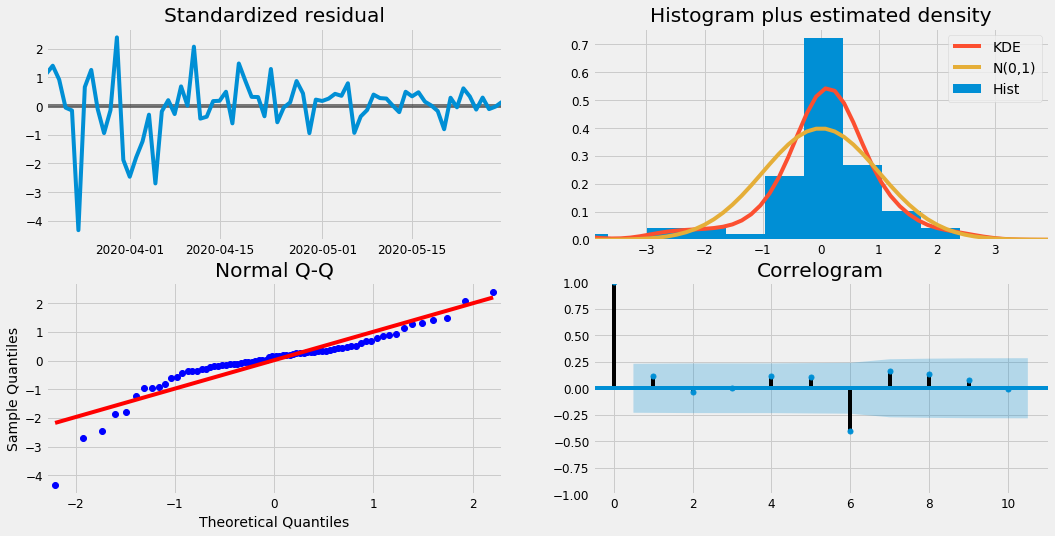

In [63]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The histogram suggests that the residuals have normal distribution.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The more close the sample quantiles to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

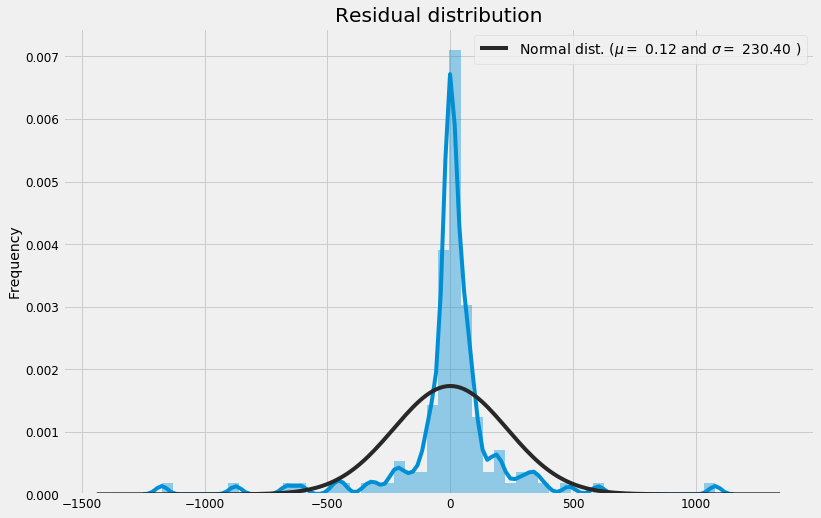

In [64]:
resid = results.resid

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high. 

# Validating forecasts

Choosing March as a reference point to start validating the forecasts.

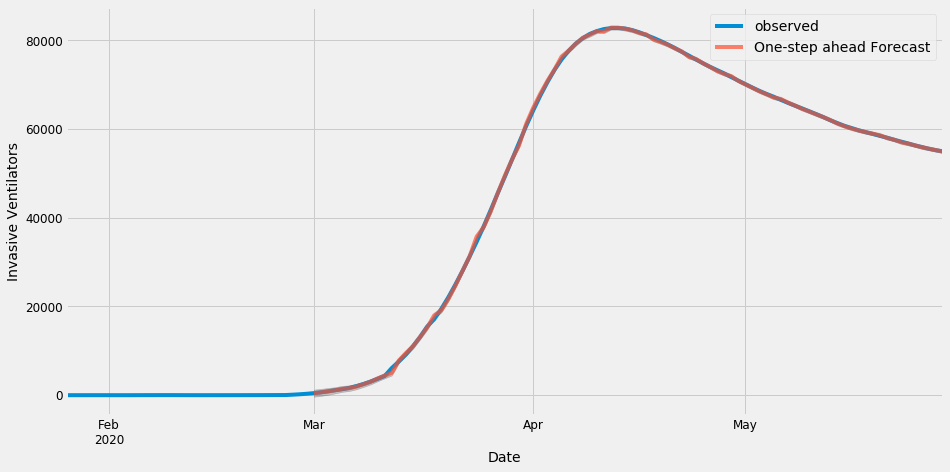

In [66]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Invasive Ventilators')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [67]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['2020-04-01':]
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 33643.58


The MSE is very low.

In [68]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 183.42


In [69]:
ts.min()

1.0

In [70]:
ts.max()

82780.80632907464

This means that the value of RMSE is 183.42. Also, the minimum and maximum values of time series is 1.0 and 82780.80632907464 respectively. Overall, this is a very good model so far.

# Visualizing forecasts

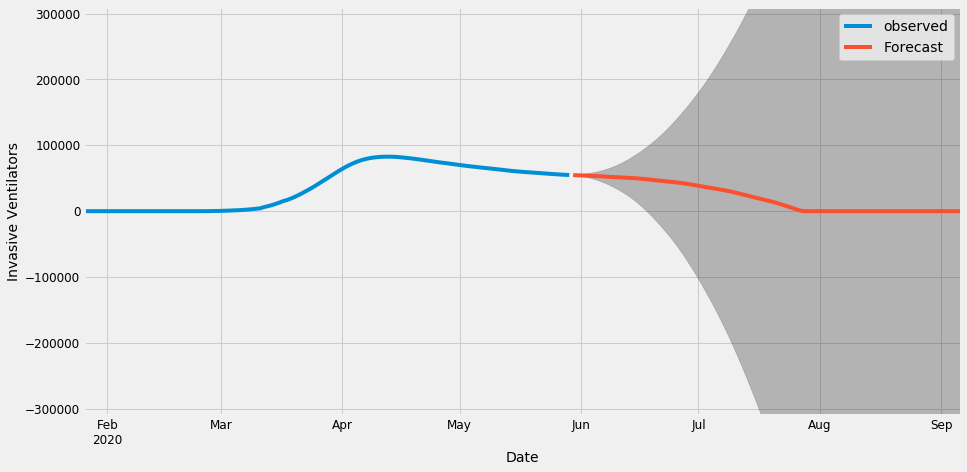

In [71]:
# Using the default confidence interval - 95%
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean[pred_uc.predicted_mean < 0] = 0
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Invasive Ventilators')
plt.ylim([-310000, 310000])
plt.legend()
plt.show()

Thus, in the future, the number of all COVID beds will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [72]:
# Setting all negative forecasted values to be 0
pred_uc.predicted_mean[pred_uc.predicted_mean < 0] = 0
pred_uc.predicted_mean

2020-05-30   54704.1210
2020-05-31   54497.3736
2020-06-01   54320.3964
2020-06-02   54135.4890
2020-06-03   53909.6500
                ...    
2020-09-02       0.0000
2020-09-03       0.0000
2020-09-04       0.0000
2020-09-05       0.0000
2020-09-06       0.0000
Freq: D, Length: 100, dtype: float64

In [73]:
pred_ci['lower value'][pred_ci['lower value'] < 0] = 0
pred_ci['upper value'][pred_ci['upper value'] < 0] = 0
pred_ci

,lower value,upper value
2020-05-30,54313.5445,55094.6976
2020-05-31,53672.9751,55321.7721
2020-06-01,52880.5500,55760.2429
2020-06-02,51872.9198,56398.0582
2020-06-03,50602.3267,57216.9734
...,...,...
2020-09-02,0.0000,1369711.0522
2020-09-03,0.0000,1402688.3356
2020-09-04,0.0000,1436271.2655
2020-09-05,0.0000,1470428.4040


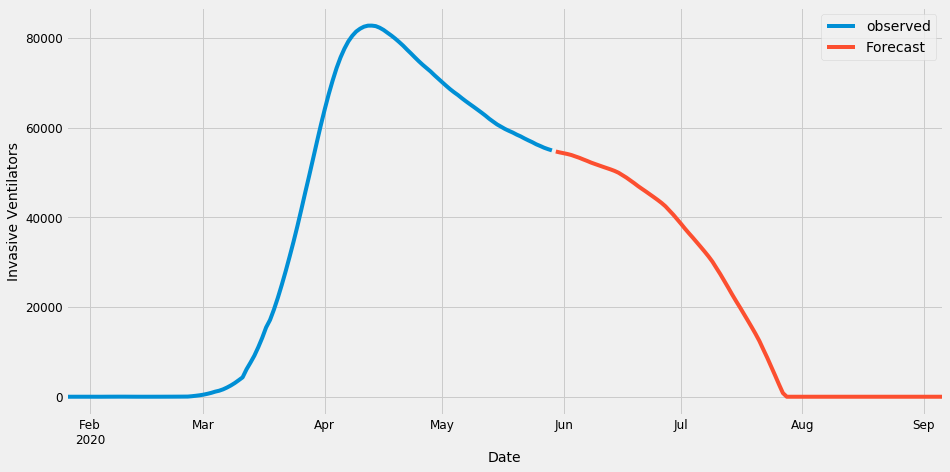

In [74]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Invasive Ventilators')
plt.legend()
plt.show()

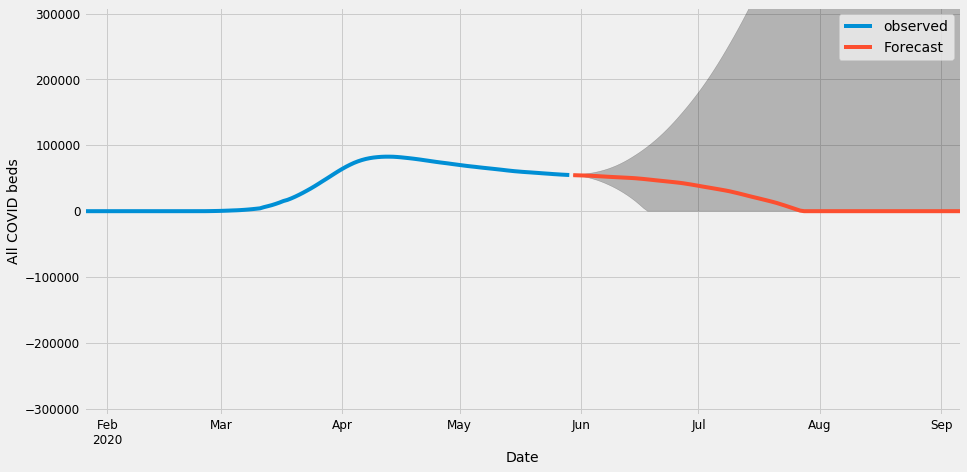

In [75]:
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.ylim([-310000, 310000])
plt.legend()
plt.show()

In [77]:
# Predictions dataframe
InvVenPredictions = pd.DataFrame({'Predicted Mean Invasive Ventilators':pred_uc.predicted_mean, 
                                   'Predicted lower value':pred_ci.iloc[:, 0], 
                                  'Predicted upper value': pred_ci.iloc[:, 1]})

In [78]:
InvVenPredictions.head(25)

,Predicted Mean Invasive Ventilators,Predicted lower value,Predicted upper value
2020-05-30,54704.1210,54313.5445,55094.6976
2020-05-31,54497.3736,53672.9751,55321.7721
2020-06-01,54320.3964,52880.5500,55760.2429
2020-06-02,54135.4890,51872.9198,56398.0582
2020-06-03,53909.6500,50602.3267,57216.9734
2020-06-04,53598.0154,49014.1502,58181.8805
2020-06-05,53297.6461,47198.8575,59396.4347
2020-06-06,52940.2330,45083.8092,60796.6568
2020-06-07,52598.6474,42741.6790,62455.6159
2020-06-08,52229.2217,40124.8653,64333.5782
